In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from ballmapper.pyBallMapper import BallMapper

In [2]:
def generate_tpf(n=100, sigma=0.1):
    unif = ss.uniform()
    norm = ss.norm(loc=0, scale=sigma)
    x = unif.rvs(n)
    def tpf_(t):
        if t<0.3: return 2*t
        if t>0.7: return 1.4-t # perhaps 1.3-t?
        return 0.6
    y = list(map(tpf_, x))
    y += norm.rvs(n)
    return x, y

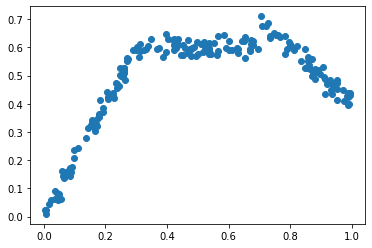

In [3]:
x, y = generate_tpf(n=200, sigma=0.02)
plt.plot(x, y, 'o')

In [13]:
def rmse_ols(n, sigma, mcloops=1000):
    rmses = []
    for mcloop in range(mcloops):
        x, y = generate_tpf(n=n, sigma=sigma)
        X = x.reshape(-1,1)
        lm = LinearRegression().fit(X,y)
        rmse = mean_squared_error(lm.predict(X), y, squared=False)
        rmses.append(rmse)
    return np.mean(rmses) 

In [14]:
sigmas = [0.02, 0.2, 0.5]
ns = [200, 500, 1000, 2000]
mcloops = 1000
rmses = []
for sigma in sigmas:
    for n in ns:
        rmses.append([sigma, n, rmse_ols(n=n, sigma=sigma, mcloops=mcloops)])

In [15]:
pd.DataFrame(rmses, columns=['sigma', 'n', 'OLS'])

,sigma,n,OLS
0,0.02,200,0.135165
1,0.02,500,0.136076
2,0.02,1000,0.136357
3,0.02,2000,0.136267
4,0.20,200,0.239125
5,0.20,500,0.240322
6,0.20,1000,0.240775
7,0.20,2000,0.241077
8,0.50,200,0.516054
9,0.50,500,0.516565


In [4]:
# This is *in-sample* only!
def rmse_bmlrg(x, y, epsilon, cut, r, substitution_policy = 'global'):
    npts = x.shape[0]
    dpts = x.shape[1]
    betas = np.zeros((npts, dpts))
    intercepts = np.zeros((npts, 1))
    counts = np.zeros((npts, 1))

    # fit global model first
    lm_global = LinearRegression().fit(x, y)
    for r_ in range(r):
        bm = BallMapper(points=x, coloring_df=pd.DataFrame(y), epsilon=epsilon)

        for node_id in bm.Graph.nodes:
            ball_pts_ind = bm.Graph.nodes[node_id]['points covered']
            if len(ball_pts_ind) >= cut:
                x_ball = x[ball_pts_ind, :]
                y_ball = y[ball_pts_ind]
                lm = LinearRegression().fit(x_ball, y_ball)
                betas[ball_pts_ind, :] += lm.coef_
                intercepts[ball_pts_ind] += lm.intercept_
            else:
                if substitution_policy == 'global':
                    betas[ball_pts_ind, :] += lm_global.coef_
                    intercepts[ball_pts_ind] += lm_global.intercept_
                else:
                    raise ValueError('Not implemented!')
            counts[ball_pts_ind] += 1
    intercepts /= counts
    betas /= counts # FIXME: is this going to work for d > 1?

    # make insample predictions
    yhat = []
    xt = np.transpose(x)
    for i in range(npts):
        yhat.append(np.matmul(betas[i, :], xt[:, i]) + intercepts[i][0])

    rmse = mean_squared_error(yhat, y, squared=False)
    return rmse

In [25]:
mcloops = 20
epsilon = 0.125 # this value more-less reproduces the results from Table 1
cut = 25
r = 20

rmses_eps = []
epsilon_list = np.linspace(0.01, 0.3, 20)
for epsilon in epsilon_list:
    rmses = []
    for mcloop in range(mcloops): 
        x, y = generate_tpf(n=200, sigma=0.02)
        x = x.reshape(-1,1)
        rmses.append(rmse_bmlrg(x=x, y=y, epsilon=epsilon, cut=cut, r=r))
    rmses_eps.append(np.mean(rmses))

Text(0.5, 1.0, 'n=200, sigma=0.02')

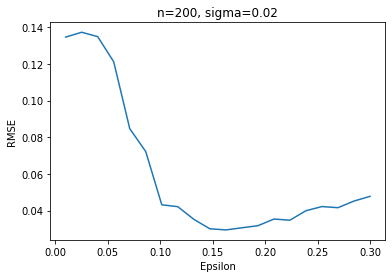

In [26]:
plt.plot(epsilon_list, rmses_eps)
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('n=200, sigma=0.02')

In [27]:
np.min(rmses_eps)

0.029445082573526637